<a href="https://colab.research.google.com/github/mett29/DL-Competition/blob/master/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# This permits to load the dataset on colab.
# We chose to take advantage of github to rapidly load all the data on colab.

from getpass import getpass
import os

user = getpass('Github user')
password = getpass('Github password')
os.environ['GITHUB_AUTH'] = user + ':' + password

!git clone https://$GITHUB_AUTH@github.com/DanieleParravicini/DL-CompetitionsDatasets
os.environ['GITHUB_AUTH'] = ''

# Of course it is not mandatory to load the dataset from a remote repo.
# You can simply unpack the kaggle competition zip in a local directory named 'DL-CompetitionsDatasets'
# As depicted below:

Github user··········
Github password··········
Cloning into 'DL-CompetitionsDatasets'...
remote: Enumerating objects: 18606, done.
remote: Total 18606 (delta 0), reused 0 (delta 0), pack-reused 18606
Receiving objects: 100% (18606/18606), 1.37 GiB | 16.15 MiB/s, done.
Resolving deltas: 100% (7114/7114), done.
Checking out files: 100% (18582/18582), done.


In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import time
import os
import numpy as np
import matplotlib.pyplot as plt

2.0.0


# Loading datasets

In [0]:
SEED = 2019
tf.random.set_seed(SEED)

In [0]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
PATH = ''
on_kaggle = False
if on_kaggle: 
  PATH = "/kaggle/input/ann-and-dl-image-segmentation/Segmentation_Dataset"
else:
  PATH = 'DL-CompetitionsDatasets/Segmentation_Dataset'
epochs = 5
batch_size = 32

In [0]:
apply_data_augmentation = True

# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    train_img_data_gen = ImageDataGenerator(rotation_range=360,
                                        zoom_range=0.5,
                                        horizontal_flip=True,
                                        vertical_flip=True,  
                                        fill_mode='nearest',                           
                                        rescale=1./255,
                                        validation_split=0.2)
    train_mask_data_gen = ImageDataGenerator(rotation_range=360,
                                        zoom_range=0.5,
                                        horizontal_flip=True,
                                        vertical_flip=True,  
                                        fill_mode='nearest',                           
                                        rescale=1./255,
                                        validation_split=0.2) 
else:
    train_img_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    train_mask_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [143]:
dataset_dir = os.path.join(PATH, 'training')

train_img_gen = train_img_data_gen.flow_from_directory(os.path.join(dataset_dir, 'images'),
                                               batch_size=batch_size,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode=None,
                                               shuffle=True,
                                               subset='training',
                                               #interpolation='bilinear',
                                               seed=SEED)

train_mask_gen = train_mask_data_gen.flow_from_directory(os.path.join(dataset_dir, 'masks'),
                                               batch_size=batch_size,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode=None,
                                               shuffle=True,
                                               subset='training',
                                               #interpolation='bilinear',
                                               color_mode='grayscale',
                                               seed=SEED)

train_gen = zip(train_img_gen, train_mask_gen)

# Validation
valid_img_gen = train_img_data_gen.flow_from_directory(os.path.join(dataset_dir, 'images'),
                                               batch_size=batch_size, 
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode=None,
                                               shuffle=False,
                                               subset='validation',
                                               #interpolation='bilinear',
                                               seed=SEED)

valid_mask_gen = train_mask_data_gen.flow_from_directory(os.path.join(dataset_dir, 'masks'),
                                               batch_size=batch_size, 
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode=None,
                                               shuffle=False,
                                               subset='validation',
                                               #interpolation='bilinear',
                                               color_mode='grayscale',
                                               seed=SEED)

valid_gen = zip(valid_img_gen, valid_mask_gen)

Found 6118 images belonging to 1 classes.
Found 6118 images belonging to 1 classes.
Found 1529 images belonging to 1 classes.
Found 1529 images belonging to 1 classes.


In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 4, figsize=(15, 15))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

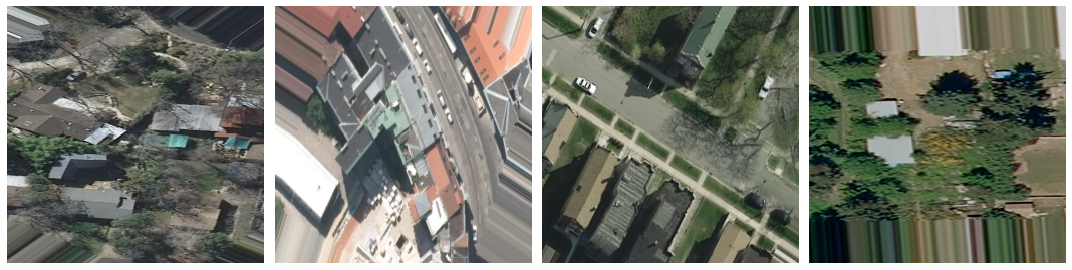

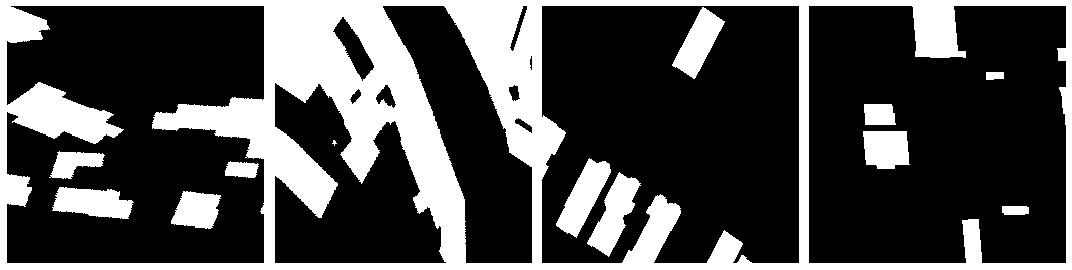

In [145]:
def grayscale_to_colour(gray_img):
  
  black = [0, 0, 0] # Background
  white = [255, 255, 255] # Buildings

  colour_img = np.zeros([gray_img.shape[0], gray_img.shape[1], 3])
  return np.where(gray_img == 1, white, black )


sample_training_images, sample_training_masks = next(train_gen)
plotImages(sample_training_images[:4])
sample_training_masks_imaged = list(map( grayscale_to_colour ,sample_training_masks[:4]))
plotImages(sample_training_masks_imaged)

In [146]:
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, IMG_HEIGHT, IMG_WIDTH, 3], [None, IMG_HEIGHT, IMG_WIDTH, 1]))

'''When using data augmentation on masks it's a good idea to cast mask tensor to tf.int32. 
When applying geometric transformations, like rotation or zoom, the output is interpolated so you will end up with values in [0, 1] 
which are no longer binary. Casting to integer will allow to obtain again binary masks.'''

def prepare_target(x_, y_):
    y2_ = tf.cast(tf.cast(y_, tf.int32), tf.float32)
    return x_, y2_

train_dataset = train_dataset.map(prepare_target)
train_dataset = train_dataset.repeat()
train_dataset.cache()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, IMG_HEIGHT, IMG_WIDTH, 3], [None, IMG_HEIGHT, IMG_WIDTH, 1]))

valid_dataset = valid_dataset.map(prepare_target)
valid_dataset = valid_dataset.repeat()
valid_dataset.cache()

<DatasetV1Adapter shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

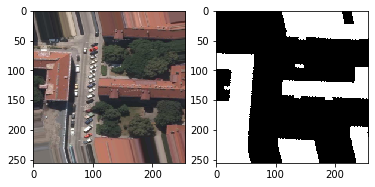

In [147]:
fig, ax = plt.subplots(1, 2)
fig.show()

colors_dict = {}
colors_dict[0] = [0, 0, 0] # Background
colors_dict[1] = [255, 255, 255] # Buildings

iterator = iter(train_dataset)

for _ in range(1):
    augmented_img, target = next(iterator)
    augmented_img = augmented_img[0]
    augmented_img = augmented_img * 255
    
    ax[0].imshow(np.uint8(augmented_img))
    ax[1].imshow(np.uint8(grayscale_to_colour(target[0])))

# Model

In [0]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = tf.keras.layers.UpSampling2D((2, 2))(x)
    concat = tf.keras.layers.Concatenate()([us, skip])
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [0]:
def UNet():
    f = [16, 32, 48, 64, 128]
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #256 -> 128
    c2, p2 = down_block(p1, f[1]) #128 -> 64
    c3, p3 = down_block(p2, f[2]) #64 -> 32
    c4, p4 = down_block(p3, f[3]) #32-> 16
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #16 -> 32
    u2 = up_block(u1, c3, f[2]) #32 -> 64
    u3 = up_block(u2, c2, f[1]) #64 -> 128
    u4 = up_block(u3, c1, f[0]) #128 -> 256
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = tf.keras.models.Model(inputs, outputs)
    return model

In [0]:
def IoU(y_true, y_pred):
    # from probability to predicted class {0, 1}
    y_pred = tf.cast(y_pred > 0.5, tf.float32) # when using sigmoid. Use argmax for softmax
    # A and B
    intersection = tf.reduce_sum(y_true * y_pred)
    # A or B
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    # IoU
    return intersection / union

In [0]:
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

In [152]:
model = UNet()

from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)


model.compile(optimizer=optimizer, loss=dice_coef, metrics=[IoU])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_86 (Conv2D)              (None, 256, 256, 16) 448         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_86[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 128, 128, 16) 0           conv2d_87[0][0]                  
____________________________________________________________________________________________

# Training

In [0]:
from datetime import datetime

callbacks = []

# Early Stopping
# --------------
early_stop = False
if early_stop:
    es_callback = tf.keras.callback.EarlyStopping(monitor='val_loss', patience=6)
    callbacks.append(es_callback)

In [154]:
model.fit(x=train_dataset,
          epochs=10,
          steps_per_epoch=len(train_img_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_img_gen), 
          callbacks=callbacks)

model.save_weights("UNet_" + str(datetime.now().strftime('%b%d_%H-%M')) + ".h5")

Train for 192 steps, validate for 48 steps
Epoch 1/10
 61/192 [========>.....................] - ETA: 1:50 - loss: 0.6557 - IoU: 0.2917

KeyboardInterrupt: ignored

#Load model from weight file



In [0]:
from ipywidgets import FileUpload
upload = FileUpload()
upload

In [0]:
for i, meta in enumerate(upload.metadata): 
    print(meta['name']) 
    with open(meta['name'], "w+b") as file_writer: 
        file_writer.write(upload.data[i])

In [0]:
#now you can load weigths 
#model.load_weights

# Collect results

In [0]:
def prediction_to_mask(prediction):
  return tf.cast(prediction > 0.5, tf.float32)

#for TRAINING purposes
image_filenames = next(os.walk(PATH+'/training/images/img'))[2]

results = {}
for image_name in image_filenames[:1]:

    img = image.load_img(os.path.join(PATH+'/training/images/img', image_name), target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_tensor = image.img_to_array(img)                    
    img_tensor = np.expand_dims(img_tensor, axis=0)         
    img_tensor /= 255. 
    
    #take the name of the file disregarding of the extension 
    name_without_ext = image_name[:-4]
    #obtain the prediction from the model
    prediction = model.predict(img_tensor)[0]
   
    #transform into a mask
    results[name_without_ext] = prediction_to_mask(prediction)


In [98]:
#results
a = np.array([[255,255,255],[0,0,0]])

np.where(a == (255,255,255), (1,1,1), (2,2,2))
 

array([[1, 1, 1],
       [2, 2, 2]])

In [0]:
def plotImageAndMask(img, mask, pred):
  plt.figure(figsize=(15, 15))
  plt.imshow(img, 'gray', interpolation='none')
  transf_mask = np.where( mask == (255,255,255), (255, 0, 0), (0,0,0) )
  plt.imshow(transf_mask, interpolation='none', alpha=0.2)
  transf_pred = np.where( pred == (255,255,255), (0, 255,0), (0,0,0) )
  plt.imshow(transf_pred, interpolation='none', alpha=0.2)
  plt.show()
  #in red what has to be captured
  #in green what is captured only by our model
  #in orange what is captured by both


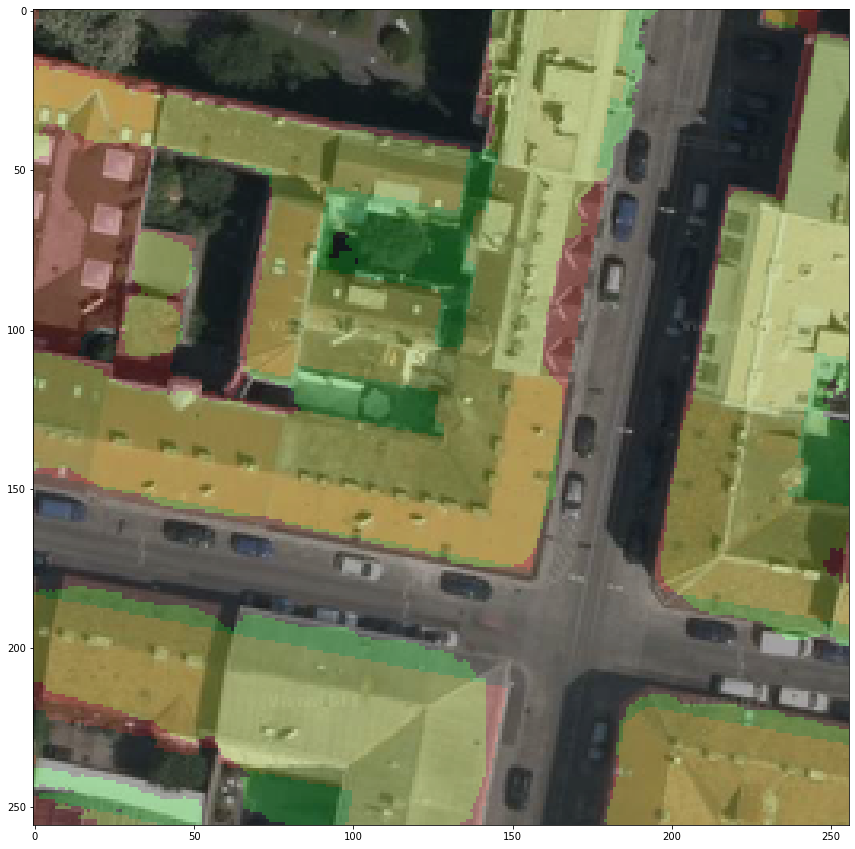

In [119]:
for image_name in image_filenames[:1]:
  

  img = image.load_img(os.path.join(PATH+'/training/images/img', image_name), target_size=(IMG_HEIGHT, IMG_WIDTH))
  mask1 = image.load_img(os.path.join(PATH+'/training/masks/img', image_name), target_size=(IMG_HEIGHT, IMG_WIDTH))
  img_tensor = image.img_to_array(img)                    
  img_tensor = np.expand_dims(img_tensor, axis=0)         
  img_tensor /= 255. 

  name_without_ext = image_name[:-4]
  pred = results[name_without_ext]

  mask2 = grayscale_to_colour(pred)
  plotImageAndMask(img, image.img_to_array(mask1), mask2)


In [0]:
def rle_encode(img):
    # Flatten column-wise
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

#for img_name in results[:1]:
#    print(rle_encode(np.array(results[img_name])))

In [0]:
def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(csv_fname, 'w') as f:

        f.write('ImageId,EncodedPixels,Width,Height\n')

        for key, value in results.items():
            f.write(key + ',' + str(rle_encode(np.array(value))) + ',' + '256' + ',' + '256' + '\n')

In [0]:
create_csv(results)